## Parcel - Global Normalization
- Comparing training and evaluating with parcel-wise normalization and globally normalization
- Choose a normalization for each dataset
- Replicate Nettekoven 2024 using best normalization

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import cortico_cereb_connectivity.run_model as rm
import matplotlib.pyplot as plt

In [2]:
def heatmap_annotate(df_to_plot, ds_order, ax, column=['train_dataset'], row=['eval_dataset'], value=['R_eval'], cmap='inferno', vmin=0, vmax=0.5):
    if 'Fusion' in ds_order:
        ds_order_y = [ds for ds in ds_order if ds!='Fusion']
    else:
        ds_order_y = ds_order
    V = pd.pivot_table(df_to_plot, columns=column, index=row, values=value)
    V = V.reindex(ds_order_y, axis=0)
    V = V.reindex(ds_order, level=1, axis=1)

    sns.heatmap(V.values, annot=True, fmt=".2f", cmap=cmap, vmin=vmin, vmax=vmax, 
                xticklabels=V.columns.get_level_values(1).values, 
                yticklabels=V.index.values, square=True, ax=ax)
    if 'Fusion' in ds_order:
        ax.axvline(len(ds_order_y), color='k', linewidth=2)

    return ax

### Loading avg and loo models

In [ ]:
method = 'L2reg'
dataset_list = ["MDTB", "Language", "WMFS", "Demand", "Somatotopic", "Nishimoto", "IBC"]
df_all_parcel = pd.DataFrame()
df_all_global = pd.DataFrame()
for dataset_name in dataset_list:
    eval_data = [eval_ds for eval_ds in dataset_list if eval_ds!=dataset_name]
    eval_data = [eval_ds if eval_ds!='Language' else 'Languagelocalizer_cond' for eval_ds in eval_data]

    # Parcel
    # Load avg performances
    df = rm.comb_eval(models=[dataset_name+"-avgparcel"],methods=[method],eval_data=eval_data,cerebellum='MNISymC3')
    df['model'] = dataset_name+"-avg"
    df_all_parcel = pd.concat([df_all_parcel, df], ignore_index=True)

    # Load loo performances
    df = rm.comb_eval(models=[dataset_name+"-looparcel"],methods=[method],eval_data=[dataset_name if dataset_name!='Language' else 'Languagelocalizer_cond'],cerebellum='MNISymC3')
    df['model'] = dataset_name+"-loo"
    df_all_parcel = pd.concat([df_all_parcel, df], ignore_index=True)

    # Global
    # Load avg performances
    df = rm.comb_eval(models=[dataset_name+"-avgglobal"],methods=[method],eval_data=eval_data,cerebellum='MNISymC3')
    df['model'] = dataset_name+"-avg"
    df_all_global = pd.concat([df_all_global, df], ignore_index=True)

    # Load loo performances
    df = rm.comb_eval(models=[dataset_name+"-looglobal"],methods=[method],eval_data=[dataset_name if dataset_name!='Language' else 'Languagelocalizer_cond'],cerebellum='MNISymC3')
    df['model'] = dataset_name+"-loo"
    df_all_global = pd.concat([df_all_global, df], ignore_index=True)

ValueError: No objects to concatenate

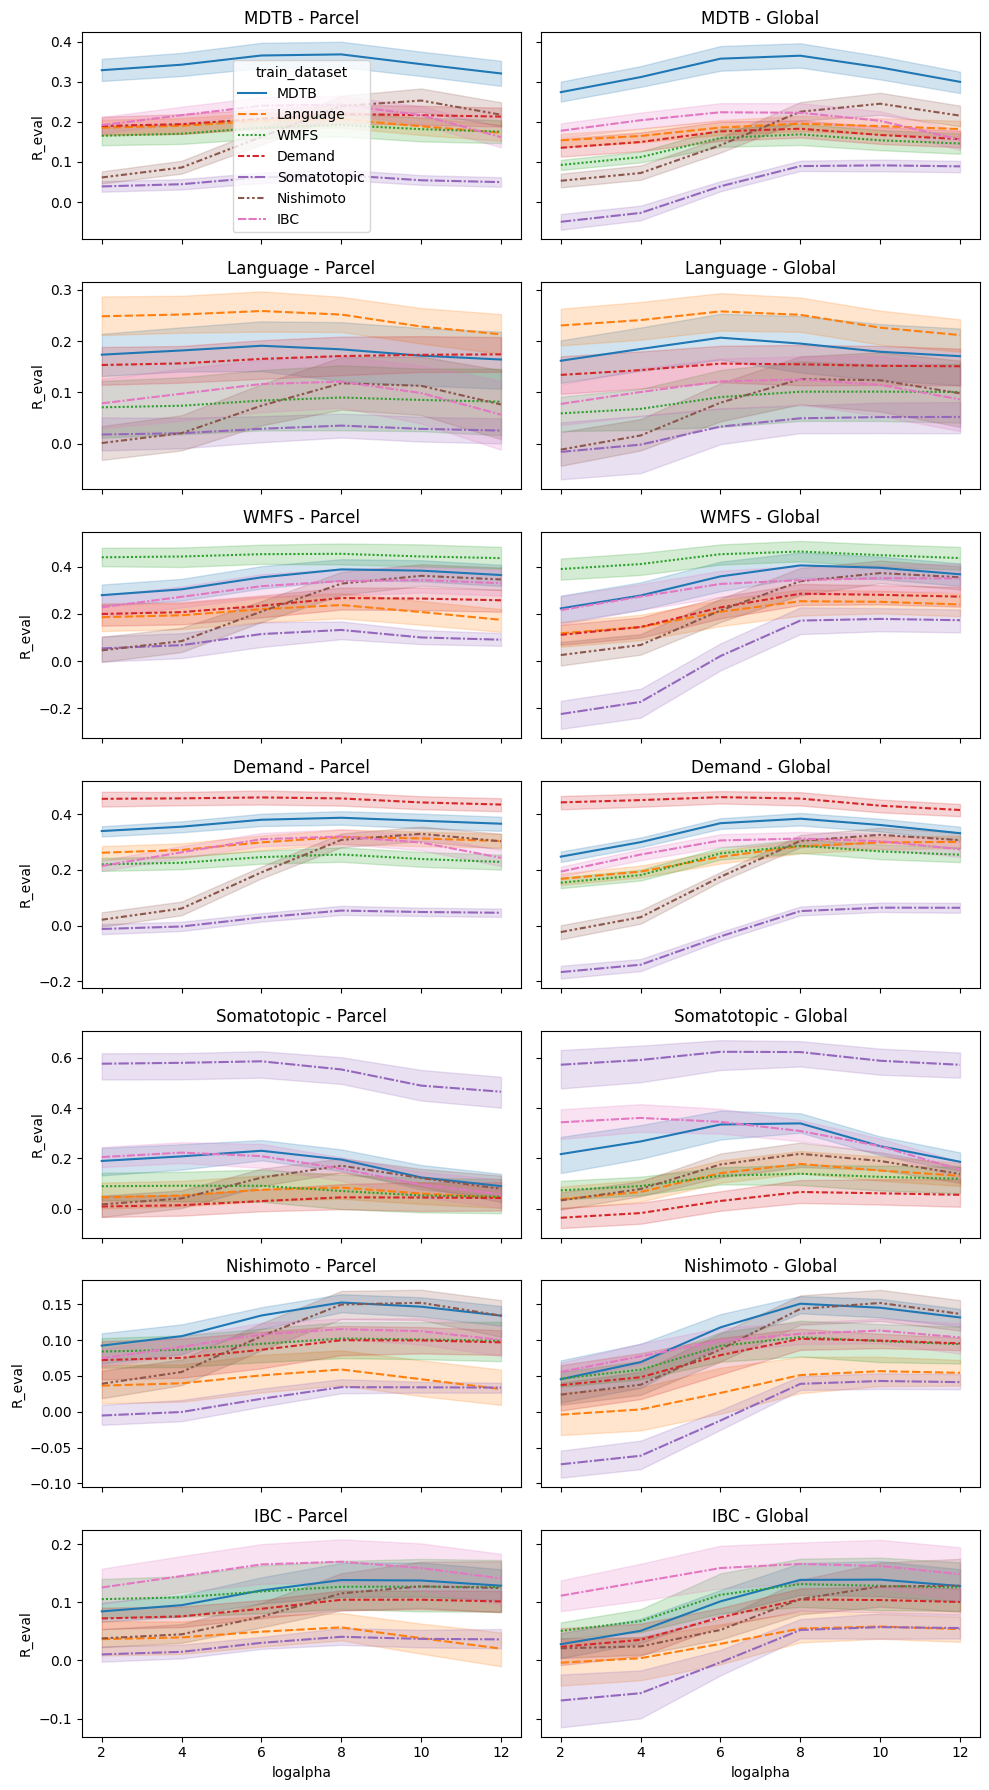

In [4]:
plt.subplots(len(dataset_list),2,figsize=(10,18), sharey='row', sharex=True)
for i,ed in enumerate(dataset_list):
    plt.subplot(len(dataset_list),2,2*i+1)
    df_to_plot = df_all_parcel[(df_all_parcel.eval_dataset==ed) & ((df_all_parcel.train_dataset!=ed) | (df_all_parcel.model.str.contains('loo')))]
    plt.title(f'{ed} - Parcel')
    if i==0:
        sns.lineplot(data=df_to_plot, y='R_eval', x='logalpha', hue='train_dataset', style='train_dataset',
                     hue_order=dataset_list, style_order=dataset_list)
    else:
        sns.lineplot(data=df_to_plot, y='R_eval', x='logalpha', hue='train_dataset', style='train_dataset',
                     hue_order=dataset_list, style_order=dataset_list, legend=None)
    plt.subplot(len(dataset_list),2,2*i+2)
    df_to_plot = df_all_global[(df_all_global.eval_dataset==ed) & ((df_all_global.train_dataset!=ed) | (df_all_global.model.str.contains('loo')))]
    plt.title(f'{ed} - Global')
    sns.lineplot(data=df_to_plot, y='R_eval', x='logalpha', hue='train_dataset', style='train_dataset',
                 hue_order=dataset_list, style_order=dataset_list, legend=None)
plt.tight_layout()

Text(0.5, 1.0, 'Global')

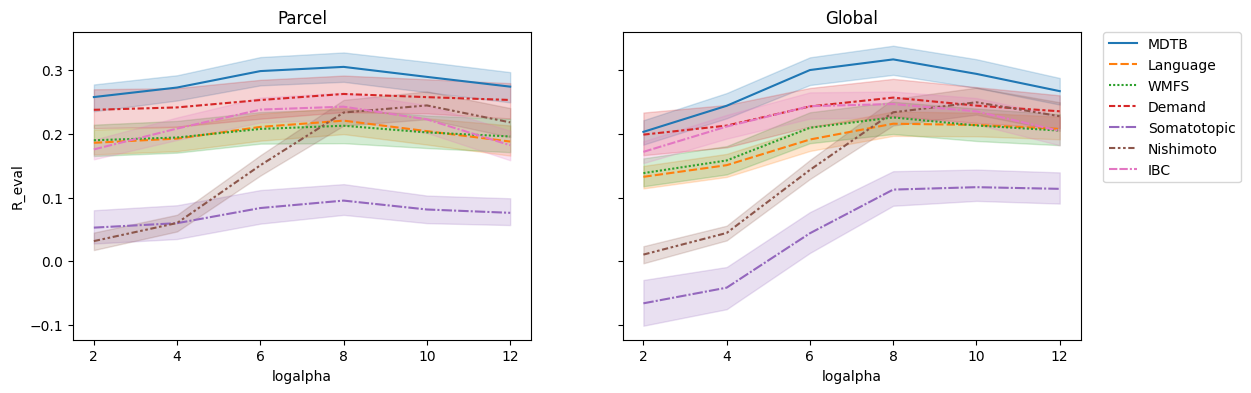

In [5]:
# Plot all evaluations on different datasets
plt.subplots(1,2,figsize=(13,4), sharey=True)

df_to_plot = df_all_parcel[(df_all_parcel.train_dataset!=df_all_parcel.eval_dataset) | (df_all_parcel.model.str.contains('loo'))]
plt.subplot(1,2,1)
sns.lineplot(data=df_to_plot, y='R_eval', x='logalpha',
             hue='train_dataset', style='train_dataset',
             hue_order=dataset_list, style_order=dataset_list, legend=None)
plt.title('Parcel')

df_to_plot = df_all_global[(df_all_global.train_dataset!=df_all_global.eval_dataset) | (df_all_global.model.str.contains('loo'))]
plt.subplot(1,2,2)
sns.lineplot(data=df_to_plot, y='R_eval', x='logalpha',
             hue='train_dataset', style='train_dataset',
             hue_order=dataset_list, style_order=dataset_list)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Global')

In [23]:
ds_order = ["Demand", "Language", "IBC", "MDTB", "Nishimoto", "Somatotopic", "WMFS"]
for i,df_to_pivot in enumerate([df_all_parcel, df_all_global]):
    A = pd.pivot_table(df_to_pivot,index=['train_dataset'],columns=['logalpha'],values=['R_eval'],aggfunc='mean').reindex(ds_order)
    display(A)
    B = np.nan_to_num(A.values)
    ind = B.argmax(axis=1)
    log_a = np.array(A.columns.get_level_values(1)[ind])
    bestla = pd.DataFrame(log_a,index=A.index,columns=['best_logalpha'])
    display(bestla)

    if i==0:
        df_all_parcel['isbest'] = df_all_parcel.logalpha.values == bestla.loc[df_all_parcel.train_dataset].values.flatten()
    else:
        df_all_global['isbest'] = df_all_global.logalpha.values == bestla.loc[df_all_global.train_dataset].values.flatten()

KeyError: 'R_eval'

### Summary Graph of all models evaluated at their best hyperparameter. 

In [ ]:
# Get cross-validated single training sets models 
d_parcel = df_all_parcel[((df_all_parcel.train_dataset!=df_all_parcel.eval_dataset) | (df_all_parcel.model.str.contains('loo'))) & df_all_parcel.isbest].reset_index(drop=True)
d_global = df_all_global[((df_all_global.train_dataset!=df_all_global.eval_dataset) | (df_all_global.model.str.contains('loo'))) & df_all_global.isbest].reset_index(drop=True)

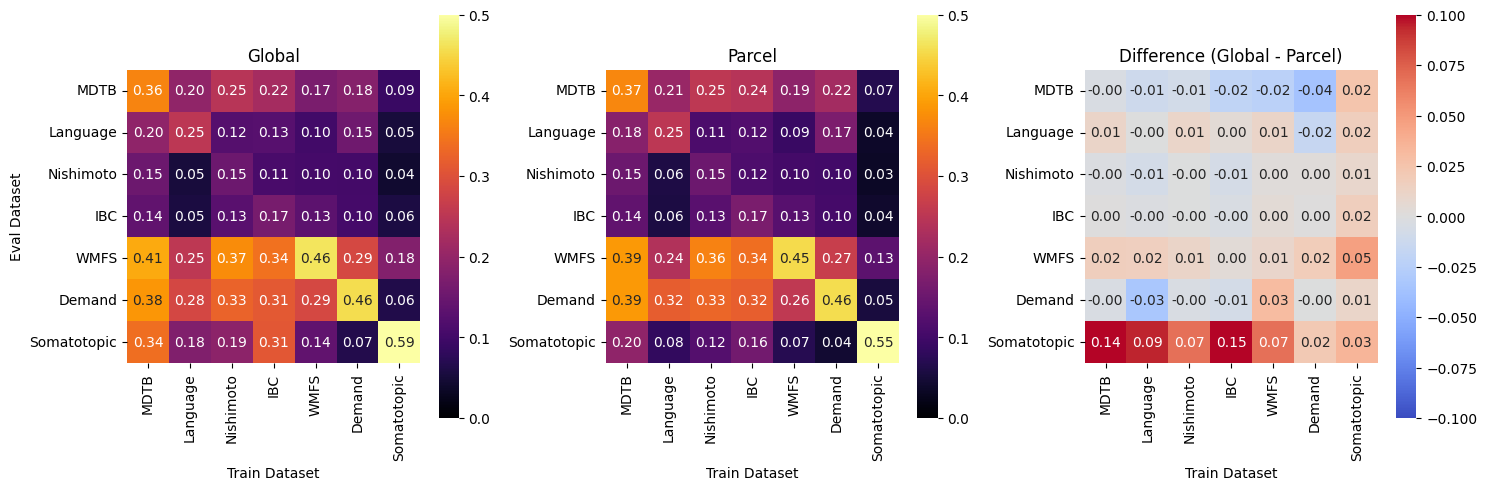

In [8]:
ds_order = ['MDTB', 'Language', 'Nishimoto', 'IBC', 'WMFS', 'Demand', 'Somatotopic']
fig, axes = plt.subplots(1,3,figsize=(15,5))

ax = heatmap_annotate(d_global, ds_order, ax=axes[0])
ax.set_title('Global')
ax.set_xlabel('Train Dataset')
ax.set_ylabel('Eval Dataset')

ax = heatmap_annotate(d_parcel, ds_order, ax=axes[1])
ax.set_title('Parcel')
ax.set_xlabel('Train Dataset')

# Calculate the difference in 'R_eval' for the same group of (train_dataset, eval_dataset, eval_subj)
df_diff = pd.merge(d_parcel[['train_dataset', 'eval_dataset', 'eval_subj', 'R_eval']],
                   d_global[['train_dataset', 'eval_dataset', 'eval_subj', 'R_eval']],
                   on=['train_dataset', 'eval_dataset', 'eval_subj'],
                   suffixes=('_parcel', '_global'))

df_diff['R_eval_diff'] = df_diff['R_eval_global'] - df_diff['R_eval_parcel']
ax = heatmap_annotate(df_diff, ds_order, ax=axes[2], value=['R_eval_diff'], cmap='coolwarm', vmin=-0.1, vmax=0.1)
ax.set_title('Difference (Global - Parcel)')
ax.set_xlabel('Train Dataset')

plt.tight_layout()

I would choose global normalization for:
- Somatotopic
- WMFS

and parcel normalization for:
- MDTB
- Language
- Nishimoto
- IBC
- Demand

## Fusion Replication

In [3]:
method = 'L2reg'
dataset_list = ["MDTB", "WMFS", "Demand", "Somatotopic", "Nishimoto", "IBC"]
df_all = pd.DataFrame()
for dataset_name in dataset_list:
    eval_data = [eval_ds for eval_ds in dataset_list if eval_ds!=dataset_name]

    # Load avg performances
    df = rm.comb_eval(models=[dataset_name+"-avg"],methods=[method],eval_data=eval_data,cerebellum='MNISymC3')
    df['model'] = dataset_name+"-avg"
    df_all = pd.concat([df_all, df], ignore_index=True)

    # Load loo performances
    df = rm.comb_eval(models=[dataset_name+"-loo"],methods=[method],eval_data=[dataset_name],cerebellum='MNISymC3')
    df['model'] = dataset_name+"-loo"
    df_all = pd.concat([df_all, df], ignore_index=True)

In [4]:
ds_order = ["Demand", "IBC", "MDTB", "Nishimoto", "Somatotopic", "WMFS"]
A = pd.pivot_table(df_all,index=['train_dataset'],columns=['logalpha'],values=['R_eval'],aggfunc='mean').reindex(ds_order)
display(A)
B = np.nan_to_num(A.values)
ind = B.argmax(axis=1)
log_a = np.array(A.columns.get_level_values(1)[ind])
bestla = pd.DataFrame(log_a,index=A.index,columns=['best_logalpha'])
display(bestla)

df_all['isbest'] = df_all.logalpha.values == bestla.loc[df_all.train_dataset].values.flatten()

R_eval                                                  
logalpha           2.0       4.0       6.0       8.0       10.0      12.0
train_dataset                                                            
Demand         0.256480  0.260781  0.274058  0.284494  0.277289  0.271465
IBC            0.210880  0.244759  0.274342  0.277669  0.256238  0.213044
MDTB           0.289134  0.303943  0.330257  0.339322  0.321832  0.303915
Nishimoto      0.038851  0.072214  0.175252  0.261818  0.274594  0.248689
Somatotopic   -0.053702 -0.025459  0.061793  0.122856  0.119965  0.115396
WMFS           0.155525  0.176516  0.228179  0.243254  0.228107  0.218341

,best_logalpha
train_dataset,
Demand,8.0
IBC,8.0
MDTB,8.0
Nishimoto,10.0
Somatotopic,8.0
WMFS,8.0


In [5]:
df = rm.comb_eval(models=["Fus06-bestSTD-nomean-norest-avg"],methods=[method],eval_data=dataset_list,cerebellum='MNISymC3')
df['model'] = 'Fusion'
df['isbest'] = True
df_Ali = pd.concat([df_all, df], ignore_index=True)

d_jorn = pd.read_csv('../data/Nettekoven2024_model_evaluations.tsv',sep='\t')
d_jorn = d_jorn[d_jorn['train_dataset']!='HCP']

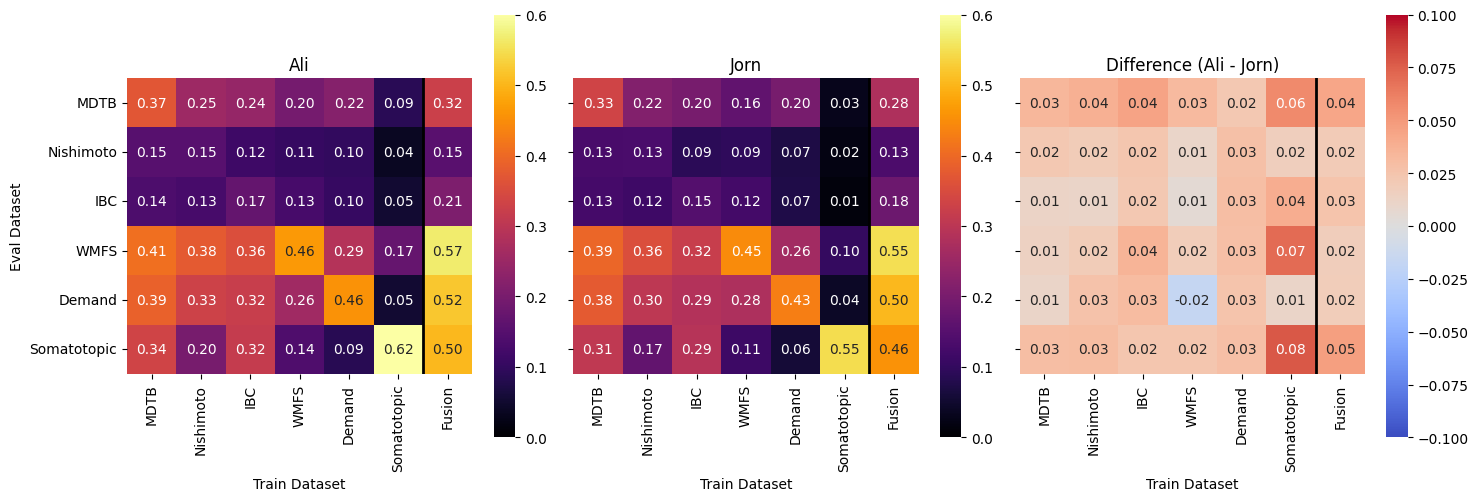

In [6]:
ds_order = ['MDTB', 'Nishimoto', 'IBC', 'WMFS', 'Demand', 'Somatotopic', 'Fusion']
df_Ali = df_Ali[((df_Ali.train_dataset!=df_Ali.eval_dataset) | (df_Ali.model.str.contains('loo'))) & df_Ali.isbest].reset_index(drop=True)
fig, axes = plt.subplots(1,3,figsize=(15,5), sharey=True, sharex=True)

ax = heatmap_annotate(df_Ali, ds_order, ax=axes[0], vmax=0.6)
ax.set_title('Ali')
ax.set_xlabel('Train Dataset')
ax.set_ylabel('Eval Dataset')

ax = heatmap_annotate(d_jorn, ds_order, ax=axes[1], vmax=0.6)
ax.set_title('Jorn')
ax.set_xlabel('Train Dataset')

# Calculate the difference in 'R_eval' for the same group of (train_dataset, eval_dataset, eval_subj)
df_diff = pd.merge(df_Ali[['train_dataset', 'eval_dataset', 'eval_subj', 'R_eval']],
                   d_jorn[['train_dataset', 'eval_dataset', 'eval_subj', 'R_eval']],
                   on=['train_dataset', 'eval_dataset', 'eval_subj'],
                   suffixes=('_Ali', '_Jorn'))

df_diff['R_eval_diff'] = df_diff['R_eval_Ali'] - df_diff['R_eval_Jorn']
ax = heatmap_annotate(df_diff, ds_order, ax=axes[2], value=['R_eval_diff'], cmap='coolwarm', vmin=-0.1, vmax=0.1)
ax.set_title('Difference (Ali - Jorn)')
ax.set_xlabel('Train Dataset')

plt.tight_layout()

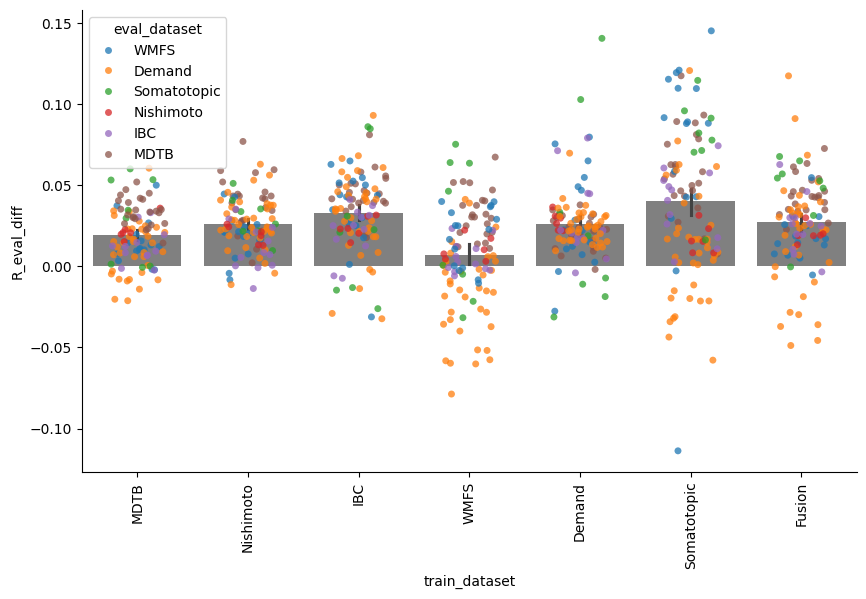

In [7]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_diff,x='train_dataset',y='R_eval_diff',order=ds_order,color=[0.5,0.5,0.5])
sns.stripplot(data=df_diff,x='train_dataset',y='R_eval_diff',hue='eval_dataset', alpha=0.75,jitter=0.25)
ax=plt.gca()
ax.set_xticks(np.arange(len(ds_order)))
ax.set_xticklabels(ds_order, rotation=90)
# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_ylim([-0.2, 0.2])